In [1]:
using Sunny, Plots
using GLMakie # Some useful plotting packages

In [2]:
a = 1
latvecs = lattice_vectors(a,a,10a,90,90,90)
crystal = Crystal(latvecs, [[0,0,0]])

Crystal
HM symbol 'P 4/m m m' (123)
Lattice params a=1, b=1, c=10, α=90°, β=90°, γ=90°
Cell volume 10
Wyckoff 1a (point group '4/mmm'):
   1. [0, 0, 0]


In [3]:
L = 3
sys = System(crystal, (L,L,1), [SpinInfo(1, S=1/2, g=1)], :dipole, units=Units.theory, seed=0)
polarize_spins!(sys, (0,0,-1))

In [4]:
#set_exchange!(sys, -1.0, Bond(1,1,(1,0,0)))

In [5]:
set_exchange!(sys,[-1.0  0.0 0.0;
                   0.0  -1.0 0.0;
                   0.0  0.0 -1.0], Bond(1, 1,(1, 0, 0)))

In [6]:
B = 0
set_external_field!(sys, (0,0,B))

In [7]:
Tc = 2/log(1+√2)
kT=Tc

2.269185314213022

In [8]:
nsweeps = 4000
sampler = LocalSampler(;kT=Tc, propose=propose_flip)
for i in 1:nsweeps
    step!(sys, sampler)
end

In [9]:
plot_spins(sys,arrowlength=0.2, linewidth=0.1, arrowsize=0.2)

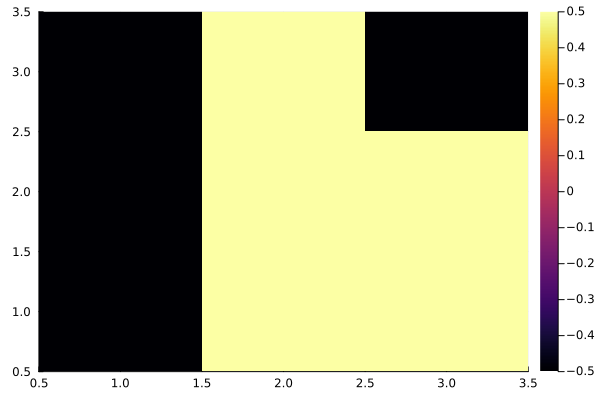

In [10]:
Plots.heatmap(reshape([s.z for s in sys.dipoles], (L,L)))

In [11]:
sf = DynamicStructureFactor(sys; Δt=0.05, ωmax=3.0, nω=100);

In [ ]:
qs = [ [1, 1, 0]]
is = intensities(sf, qs, :perp)

fig = Figure()
ax = Axis(fig[1,1]; xlabel="meV", ylabel="Intensity")
l1 = lines!(ax, ωs(sf), is[1,:])
Legend(fig[1,2], [l1], ["first"])
fig

In [ ]:
points = [[0,   0, 0],  # List of wave vectors that define a path
          [1,   1, 0],]
density = 80
path, markers = connected_path(points, density);

formfactors = [FormFactor(1, "Nd3"; g_lande=0.78)]
is = intensities(sf, path, :perp;
    interpolation = :linear,       # Interpolate between available wave vectors
    kT,                            # Temperature for intensity correction
    formfactors,                   # Form factor information
)
is = broaden_energy(sf, is, (ω, ω₀)->lorentzian(ω-ω₀, 0.005))  # Add artificial broadening

labels = ["($(p[1]),$(p[2]),$(p[3]))" for p in points]

GLMakie.heatmap(1:size(is,1), ωs(sf), is;
    colorrange=(0, 5),
    axis = (
        ylabel = "meV",
        xticks = (markers, labels),
        xticklabelrotation=π/8,
        xticklabelsize=12,
    )
)